# Process

Tăng số lượng ảnh lên $3$ lần  với các phép xoay, lật, tăng sáng, thêm nhiễu muối, biến đổi affine...

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Đường dẫn
input_dir = "data/Data"
output_dir = "data/Data_x3"
os.makedirs(output_dir, exist_ok=True)

# # Pipeline tăng cường
# augmentations = [
#     A.Compose([A.HorizontalFlip(p=1), A.RandomBrightnessContrast(p=1)]),
#     A.Compose([
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=1),
#         A.OneOf([
#                 A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.5),
#                 A.MotionBlur(p=0.3),
#                 A.ImageCompression(quality_lower=80, quality_upper=100, p=0.3),
#             ], 
#             p=0.7
#         )
#     ]),
#     A.Compose([A.RandomBrightnessContrast(p=0.5), A.HorizontalFlip(p=0.5)])
# ]
augmentations = [
    A.Compose([
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=0.5)
    ]),
    A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=1),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.5)
    ]),
    A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.3)
    ])
]


# Duyệt qua từng classes
for c in os.listdir(input_dir):
    os.makedirs(f'{output_dir}/{c}', exist_ok=True)
    # Duyệt qua từng ảnh
    for fname in tqdm(os.listdir(f'{input_dir}/{c}'), ncols=100, colour="green", desc=c):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            img = cv2.imread(os.path.join(f'{input_dir}/{c}', fname))
            base = os.path.splitext(fname)[0]

            # Lưu ảnh gốc
            cv2.imwrite(os.path.join(f'{output_dir}/{c}', f"{base}_orig.png"), img)

            # Tạo và lưu augment
            for i, aug in enumerate(augmentations):
                aug_img = aug(image=img)["image"]
                cv2.imwrite(os.path.join(f'{output_dir}/{c}', f"{base}_aug{i+1}.png"), aug_img)


/tmp/ipykernel_2253115/1407834147.py:33: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.5)
osteopenia: 100%|█████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.09it/s]


# Enhance

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tools.process import is_blurry, unsharp_mask, adjust_gamma, enhance_xray

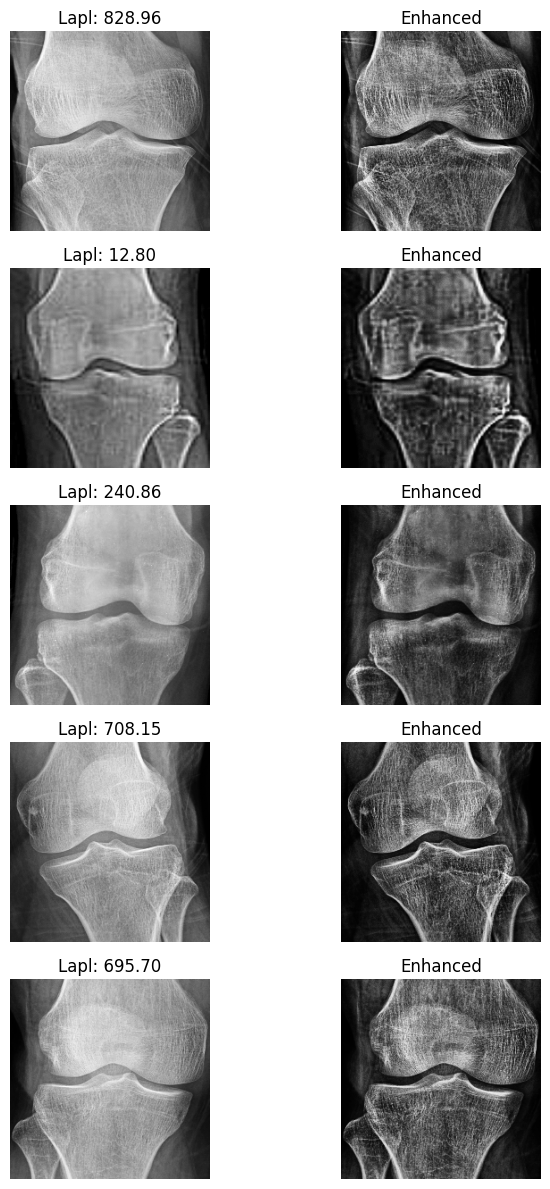

In [ ]:
data_path = "data/Data_x3_ROI/osteoporosis"
image_paths = os.listdir(data_path)[:5]

# Tạo grid 5x2 (5 hàng, 2 cột)
fig, axs = plt.subplots(5, 2, figsize=(8, 12))

for i, path in enumerate(image_paths):
    image_path = os.path.join(data_path, path)
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_rgb = cv2.cvtColor(cv2.resize(image_gray, (224, 224)), cv2.COLOR_GRAY2RGB)
    # Kiểm tra độ mờ
    blurry, score = is_blurry(image_rgb, threshold=100)

    # Nếu mờ, áp dụng khử mờ bằng unsharp mask
    if blurry:
        image_deblur = unsharp_mask(image_rgb)
        image_gray = cv2.cvtColor(image_deblur, cv2.COLOR_RGB2GRAY)
    else:
        image_deblur = image_gray.copy()
    
    # Tăng cường ảnh
    image_enhance = enhance_xray(image_gray)

    axs[i, 0].imshow(image_gray, cmap='gray')
    axs[i, 0].set_title(f"Lapl: {score:.2f}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(image_enhance)
    axs[i, 1].set_title(f"Enhanced")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

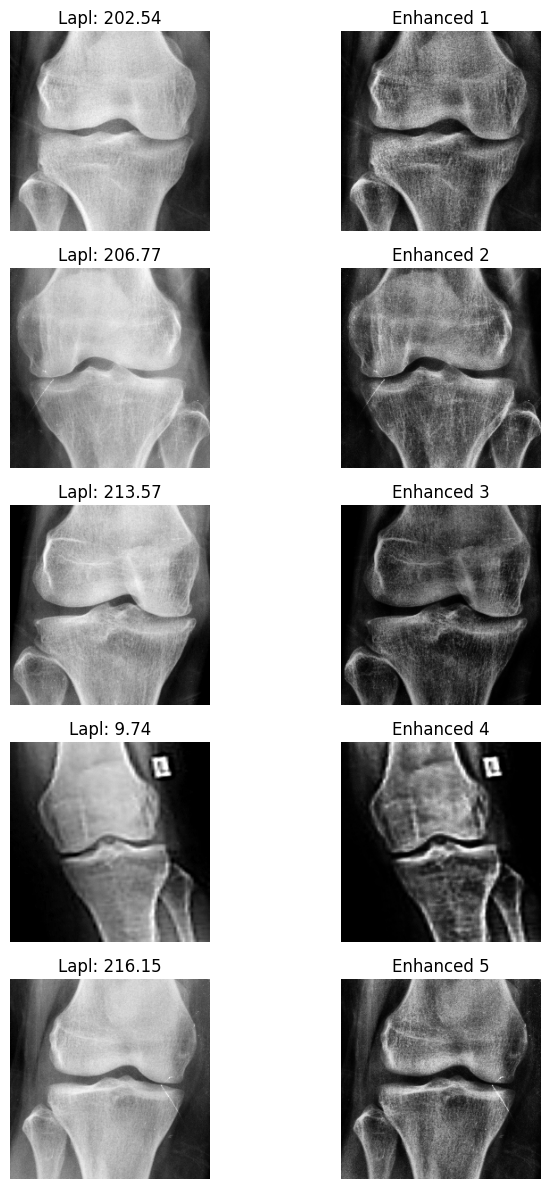

In [ ]:
data_path = "data/Data_x3_ROI/normal"
image_paths = os.listdir(data_path)[:5]

# Tạo grid 5x2 (5 hàng, 2 cột)
fig, axs = plt.subplots(5, 2, figsize=(8, 12))

for i, path in enumerate(image_paths):
    image_path = os.path.join(data_path, path)
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_rgb = cv2.cvtColor(cv2.resize(image_gray, (224, 224)), cv2.COLOR_GRAY2RGB)
    # Kiểm tra độ mờ
    blurry, score = is_blurry(image_rgb, threshold=100)

    # Nếu mờ, áp dụng khử mờ bằng unsharp mask
    if blurry:
        image_deblur = unsharp_mask(image_rgb)
        image_gray = cv2.cvtColor(image_deblur, cv2.COLOR_RGB2GRAY)
    else:
        image_deblur = image_gray.copy()
    
    # Tăng cường ảnh
    image_enhance = enhance_xray(image_gray)

    axs[i, 0].imshow(image_gray, cmap='gray')
    axs[i, 0].set_title(f"Lapl: {score:.2f}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(image_enhance)
    axs[i, 1].set_title(f"Enhanced {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm

# Đường dẫn gốc và đầu ra
input_root = "data/Data_x3_ROI"
output_root = "data/Data_x3_ROI_enhance"
os.makedirs(output_root, exist_ok=True)

# Duyệt 2 class: normal, osteoporosis
for label in os.listdir(input_root):
    input_class_dir = os.path.join(input_root, label)
    output_class_dir = os.path.join(output_root, label)
    os.makedirs(output_class_dir, exist_ok=True)

    # Duyệt từng ảnh trong class
    for fname in tqdm(os.listdir(input_class_dir), desc=f"Processing {label}", ncols=100, colour="green"):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_class_dir, fname)
            image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Resize & convert để kiểm tra độ mờ
            image_rgb = cv2.cvtColor(cv2.resize(image_gray, (224, 224)), cv2.COLOR_GRAY2RGB)
            blurry, score = is_blurry(image_rgb, threshold=100)

            # Nếu mờ → khử mờ
            if blurry:
                image_deblur = unsharp_mask(image_rgb)
                image_gray = cv2.cvtColor(image_deblur, cv2.COLOR_RGB2GRAY)

            # Tăng cường ảnh
            image_enhance = enhance_xray(image_gray)

            # Lưu kết quả
            save_path = os.path.join(output_class_dir, fname)
            cv2.imwrite(save_path, image_enhance)


Processing osteoporosis: 100%|█████████████████████████████████| 3308/3308 [00:08<00:00, 405.39it/s]
